In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

import sympy as sp
from scipy.optimize import curve_fit, OptimizeWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)

# LUCRO
O objetivo é encontrar os parâmetros necessários para se obter o lucro máximo em certos produtos do restaurante, o lucro é definido por

$$L(p, q) = \text{Receita} - \text{Custo}$$

Como a receita é dada pelo produto do preço vendido e a quantidade vendida, pode-se reduzir a formula a:

$$L(p, q) = R(p, q) - C_V - C_F$$

$$L(p, q) = p \cdot q - q \cdot C_{VI} - C_{FI}$$

Onde $C_{VI}$ é o custo variável daquele produto e $C_{FI}$ é o custo fixo individual daquele produto, ou seja, a parcela dos custos fixos que aquele produto deve cobrir com base nas suas vendas. 


In [207]:
desiredProduct = 'Hambúrguer'
pd.ExcelFile('Products.xlsx').sheet_names

['CustosVariaveis', 'CustosFixos', 'Pratos', 'CustosExtras', 'Vendas']

### ENCONTRANDO O PRODUTO DESEJADO

In [208]:
plate_df = pd.read_excel('Products.xlsx', 'Pratos')
plate_df.head()

,Nome do Prato,Ingredientes
0,Pizza,"[{""ingrediente"": ""Massa de Pizza"", ""Quantidade..."
1,Hambúrguer,"[{""ingrediente"": ""Carne"", ""Quantidade Comprada..."
2,Salada Caesar,"[{""ingrediente"": ""Alface"", ""Quantidade Comprad..."
3,Frango Assado,"[{""ingrediente"": ""Frango"", ""Quantidade Comprad..."
4,Risoto de Camarão,"[{""ingrediente"": ""Arroz"", ""Quantidade Comprada..."


In [209]:
target = plate_df[plate_df['Nome do Prato'] == desiredProduct].iloc[0]
target

Nome do Prato                                           Hambúrguer
Ingredientes     [{"ingrediente": "Carne", "Quantidade Comprada...
Name: 1, dtype: object

In [210]:
ingredientsInfo = pd.DataFrame(json.loads(target['Ingredientes']))
ingredientsInfo.rename(columns={'ingrediente': 'Nome'}, inplace=True)

ingredientsInfo

,Nome,Quantidade Comprada,Volume Produzido
0,Carne,2.5,20
1,Pão,20.0,20
2,Alface,2.0,20
3,Tomates,1.0,20
4,Queijo,0.5,20


- A nova coluna mostra a quantidade daquele ingrediente necessária para fazer aquele prato, por exemplo, são necessários 0.125 kg de carne para fazer 1 unidade daquele prato

In [211]:
ingredientsInfo['Quantidade/Unidade'] = ingredientsInfo['Quantidade Comprada']/ingredientsInfo['Volume Produzido']
ingredientsInfo

,Nome,Quantidade Comprada,Volume Produzido,Quantidade/Unidade
0,Carne,2.5,20,0.125
1,Pão,20.0,20,1.000
2,Alface,2.0,20,0.100
3,Tomates,1.0,20,0.050
4,Queijo,0.5,20,0.025


### ENCONTRANDO OS CUSTOS VARIÁVEIS

In [212]:
ingredients_df = pd.read_excel('Products.xlsx', 'CustosVariaveis')
ingredients_df.head()

,Nome,Quantidade Comprada,Unidade de Medida,Custo Total (R$)
0,Carne,10,kg,300
1,Batatas,20,kg,60
2,Tomates,15,kg,45
3,Queijo,5,kg,80
4,Frango,10,kg,120


- Encontrando o custo variável unitário, ou seja, o preço necessário para comprar 1 unidade do ingrediente

In [213]:
ingredients_df['Custo Variável (R$)'] = ingredients_df['Custo Total (R$)']/ingredients_df['Quantidade Comprada']
ingredients_df.head()

,Nome,Quantidade Comprada,Unidade de Medida,Custo Total (R$),Custo Variável (R$)
0,Carne,10,kg,300,30.0
1,Batatas,20,kg,60,3.0
2,Tomates,15,kg,45,3.0
3,Queijo,5,kg,80,16.0
4,Frango,10,kg,120,12.0


In [214]:
desiredIngredients = ingredientsInfo['Nome'].tolist()
print(desiredIngredients)

target = ingredients_df.loc[ingredients_df['Nome'].isin(desiredIngredients)]
target

['Carne', 'Pão', 'Alface', 'Tomates', 'Queijo']


,Nome,Quantidade Comprada,Unidade de Medida,Custo Total (R$),Custo Variável (R$)
0,Carne,10,kg,300,30.0
2,Tomates,15,kg,45,3.0
3,Queijo,5,kg,80,16.0
5,Alface,10,unidades,30,3.0
6,Pão,50,unidades,50,1.0


In [215]:
target = pd.merge(target, ingredientsInfo[['Nome', 'Quantidade/Unidade']], on='Nome')
target

,Nome,Quantidade Comprada,Unidade de Medida,Custo Total (R$),Custo Variável (R$),Quantidade/Unidade
0,Carne,10,kg,300,30.0,0.125
1,Tomates,15,kg,45,3.0,0.050
2,Queijo,5,kg,80,16.0,0.025
3,Alface,10,unidades,30,3.0,0.100
4,Pão,50,unidades,50,1.0,1.000


- O custo variável vai ser a soma de todos os custos variáveis individuais, ou seja, necessários para fazer 1 unidade daquele item

In [216]:
custoVariavel = (target['Custo Variável (R$)'] * target['Quantidade/Unidade']).sum()
custoVariavel

5.6

### ENCONTRANDO OS CUSTOS FIXOS

In [217]:
fix_df = pd.read_excel('Products.xlsx', 'CustosFixos')
fix_df.head()

,Descrição do Custo Fixo,Valor Mensal (R$)
0,Aluguel do Espaço,2000
1,Salários dos Funcionários (incluindo encargos),4000
2,Seguro,100
3,Conta de Energia Elétrica,800
4,Conta de Água,400


In [218]:
custoFixoTotal = fix_df['Valor Mensal (R$)'].sum()
custoFixoTotal

9950

- Agora precisamos dividir os custos totais entre os produtos (pratos) para encontrarmos o preço que cada 1 deve ter. 

- Uma abordagem é dividir os custos fixos proporcionalmente com base na receita ou no volume de vendas de cada produto.

- Ex: Se um produto representa 30% da receita total, ele seria alocado com 30% dos custos fixos. Para fazer isso, vamos usar uma pequena amostra de vendas anteriores

In [219]:
sales_df = pd.read_excel('Products.xlsx', sheet_name='Vendas')
sales_df.head()

,Nome do Prato,Preço Vendido (R$),Data da Venda,Hora da Venda
0,Pizza,30,2024-01-03,19:00:00
1,Salada Caesar,28,2024-01-03,19:30:00
2,Pizza,28,2024-01-03,19:45:00
3,Risoto de Camarão,40,2024-01-03,20:00:00
4,Hambúrguer,22,2024-01-03,20:15:00


In [220]:
totalIncome  = sales_df['Preço Vendido (R$)'].sum()
targetIncome = sales_df.loc[sales_df['Nome do Prato'] == desiredProduct]['Preço Vendido (R$)'].sum()

percentageIncome = targetIncome/totalIncome
percentageIncome

0.10835058661145618

- Isso significa que 11% da receita total do restaurante vem desse prato, então o custo fixo para esse prato deve ser 11% do custo fixo total

In [221]:
custoFixo = custoFixoTotal*percentageIncome
custoFixo

1078.088336783989

### PONTO DE EQUILÍBRIO (BREAK POINT)
- O ponto de equilíbrio ocorre quando o total de receitas iguala o total de custos (fixos e variáveis), o que significa que não há lucro nem prejuízo. Ou seja, significa que $L(p, q) = 0$

$$0 = p\cdot q - q \cdot C_V - C_{F}$$

$$q = \frac{C_F}{p - C_V}$$

- Para encontrar o preço do produto $p$, vamos considerar a média dos preços já vendidos, ou o preço de mercado caso não tenha vendido ainda

In [222]:
p = sales_df.loc[sales_df['Nome do Prato'] == desiredProduct]['Preço Vendido (R$)'].max()
p

22

In [223]:
def qBreakpoint(p, Cv, Cf):
    return Cf / (p - Cv)

qBreakpoint(p, custoVariavel, custoFixo)

65.7370937063408

- Ou seja, precisamos vender no mínimo $q=66$ unidades ao preço de $p=22$ para obter algum lucro

### ELASTICIDADE PREÇO DA DEMANDA
- A elasticidade-preço da demanda $\epsilon$ é uma medida que indica como a quantidade demandada de um produto ou serviço responde a mudanças no preço.

$$\epsilon = \frac{\triangle Q \%}{\triangle P \%} = \frac{\frac{Q-Q_0}{Q_0}}{\frac{P-P_0}{P_0}}$$

- Onde $Q$ e $Q_0$ são respectivamente a quantidade inicial e final vendidas a partir de uma variação de preço de $P_0$ para $P$

- Quando $|\epsilon| > 1$, a demanda é elástica, ou seja, o produto é sensível à variações de preço, e se eu aumentar um pouquinho o preço, isso irá refletir em menos pessoas comprando o produto, e portanto, uma arrecadação menor na receita. Se for menor do que 1, a demanda é inelástica, ou seja, posso aumentar mais o preço que as pessoas não vão deixar de comprar (significativamente)


In [224]:
target = sales_df.loc[sales_df['Nome do Prato'] == desiredProduct]
target.head()

,Nome do Prato,Preço Vendido (R$),Data da Venda,Hora da Venda
4,Hambúrguer,22,2024-01-03,20:15:00
13,Hambúrguer,22,2024-01-05,19:30:00
20,Hambúrguer,20,2024-01-06,13:00:00
25,Hambúrguer,20,2024-01-06,18:45:00
30,Hambúrguer,20,2024-01-03,19:15:00


In [225]:
P0 = target['Preço Vendido (R$)'].min()
P  = target['Preço Vendido (R$)'].max()

Q0 = (target['Preço Vendido (R$)'] == P0).sum()
Q = (target['Preço Vendido (R$)'] == P).sum()

In [226]:
(P0, Q0, P, Q)

(20, 8, 22, 7)

In [227]:
def elasticidade(Q0, Q, P0, P):
    return ((Q-Q0)/Q0) / ((P-P0)/P0)

e = elasticidade(Q0, Q, P0, P)
e

-1.25

- Então temos que a demanda desse produto é elástica, não podemos aumentar o preço, deixa em 20 mermo que ta bom

### LUCRO MÁXIMO
Para encontrar o lucro máximo, primeiro precisamos encontrar a fórmula do lucro
$$L(p, q) = p\cdot q - q\cdot C_{VI} - C_{FI}$$

Precisamos fazer com que L seja uma função só de $p$ para podermos encontrar o preço desejado para o produto que vamos vender, e assim também a quantidade. Ou seja, precisamos encontrar $q(p)$, como temos poucos pontos, o mais geral é a aproximar por uma função linear

In [228]:
target = sales_df.loc[sales_df['Nome do Prato'] == desiredProduct]

prices     = target['Preço Vendido (R$)'].unique()
quantities = [(target['Preço Vendido (R$)'] == price).sum() for price in prices]

print(prices, quantities) # x e y, q(p)

[22 20] [7, 8]


In [229]:
def curveFit(xData, yData, function):
    coef = curve_fit(function, xData, yData, maxfev=2100000000)
    return list(coef[0])

def q_generic(p, a, b):
    return a*p + b

p = sp.var('p')
Q = q_generic(p, *curveFit(xData=prices, yData=quantities, function=q_generic))

Q

18.0 - 0.5*p

In [230]:
L = p*Q - Q * custoVariavel - custoFixo
L

p*(18.0 - 0.5*p) + 2.8*p - 1178.88833678399

In [231]:
xData = np.linspace(0, 40, 1000)
yData = sp.lambdify(p, L, modules='numpy')(xData)

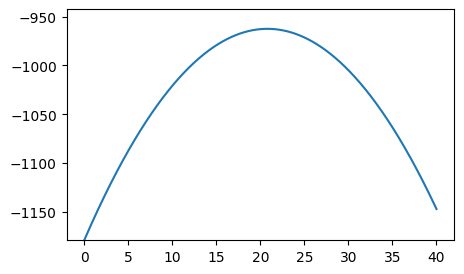

In [232]:
plt.figure(figsize=(5, 3))
plt.plot(xData, yData)

plt.ylim(min(yData), max(yData)+20)
plt.show()

In [233]:
lucroMaximo = max(yData)
quantidade  = xData[yData == lucroMaximo]

lucroMaximo, quantidade

(-962.5685214731839, array([20.78078078]))

- Isso faz sentido? o lucro máximo está dando negativo

- Sim, como calculamos anteriormente, precisariamos vender $q=66$ unidades desse produto a $p=22$ reais para ter um lucro positivo. Entretanto, pelo comportamento observado na elasticidade-demanda, conforme vamos aumentando o peço as pessoas vão parando de comprar e a quantidade $q$ diminiu. De forma que nunca vamos conseguir vender $q=66$ com $p=22$, já que nesse preço, a quantidade máxima comprada seria de:

In [234]:
Q.subs(p, 22)

7.00000000000000

E isso não é 22, que é o mínimo para ter lucro. Ou seja, esse produto nunca vai dar lucro, pare de vendê-lo

### CUSTO MARGINAL
- Aumentar a produção de certo produto irá também aumentar o custo para produzi-lo, mas nem sempre essa relação é linear, o que significa que talvez o custo aumente muito para um pequeno aumento na quantidade produzido, afetando negativamente o lucro. 

- Os custos que podem aumentar são, por exemplo, contas de luz, contas de água, máquinário novo, novos funcionários, ETC. Todos esses novos custos foram inclusos na coluna de "Custo Extra", como mostrado abaixo

$$L(p, q) = p\cdot q - C_V - C_{VE}(q) - C_F$$

- Onde $C_{VE}$ é o custo variável extra para uma certa quantidade de produção $q$, então é preciso encontrar a função $C_{VE}(q)$

In [235]:
extra_expenses = pd.read_excel('Products.xlsx', sheet_name='CustosExtras')
extra_expenses[-5:].head()

,Nome do Prato,Quantidade Produzida,Custos Extras (R$)
21,Salada Simples,300,23123
22,Sanduíche Vegetariano,300,543
23,Salada de Arroz,300,32432
24,Bruschetta,300,323
25,Omelete,300,43223


In [236]:
target = extra_expenses.loc[extra_expenses['Nome do Prato'] == desiredProduct]
target

,Nome do Prato,Quantidade Produzida,Custos Extras (R$)
1,Hambúrguer,100,0
14,Hambúrguer,300,300


- PComo não podemos obter valores negativos, não podemos usar a função linear dessa vez, então a função genérica almejada será:

$$y(x) = a\cdot b^{x-c}$$

Como só temos dois pontos, vamos adicionar o ponto $y(0) = 0$ já que sabemos que $Cv$ não pode ser negativo para $q=0$

In [237]:
def Cve_generic(q, a, b, c):
    return a*b**(q-c)

q = sp.var('q')

xData = [0] + target['Quantidade Produzida'].tolist()
yData = [0] + target['Custos Extras (R$)'].tolist()

Cve = Cve_generic(q, *curveFit(xData, yData, function=Cve_generic))

display(Cve)
print(Cve.subs(q, 0), Cve.subs(q, 100), Cve.subs(q, 300))

0.0015811759788289*1.10678835068126**(q - 180.218054525619)

1.81028701120349e-11 4.61535780352436e-7 299.999999998385


In [238]:
Cve = Cve.subs(q, Q)

display(Q)
display(Cve)

18.0 - 0.5*p

0.0015811759788289*1.10678835068126**(-0.5*p - 162.218054525619)

In [239]:
L = p*Q - custoVariavel*Q - Cve - custoFixo
L

-0.0015811759788289*1.10678835068126**(-0.5*p - 162.218054525619) + p*(18.0 - 0.5*p) + 2.8*p - 1178.88833678399

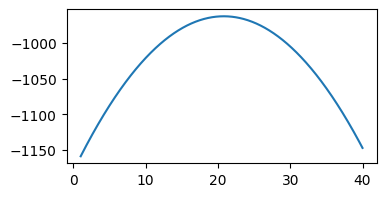

In [240]:
f = sp.lambdify(p, L, modules='numpy')

xData = np.linspace(1, 40, 1000)
yData = [f(x) for x in xData]

plt.figure(figsize=(4, 2))
plt.plot(xData, yData)

In [241]:
lucroMaximo = max(yData)
quantidade  = xData[yData == lucroMaximo]

lucroMaximo, quantidade

(-962.5683627559472, array([20.79279279]))